### KMeans drawbacks
- lack of flexibility in cluster shape 
- lack of probabilistic cluster assignment

### KMeans extension:

__GMM is an extension of the ideas behind *k*-means beyond simple clustering__ 

because in particular, the non-probabilistic nature of *k*-means and its use of simple distance-from-cluster-center to assign cluster membership leads to poor performance for many real-world situations.

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16,8)
import seaborn as sns; sns.set()
import numpy as np

## Motivating GMM: Weaknesses of k-Means

given simple, well-separated data, *k*-means finds suitable clustering results.

For example, if we have simple blobs of data, the *k*-means algorithm can quickly label those clusters in a way that closely matches what we might do by eye:

In [6]:
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)

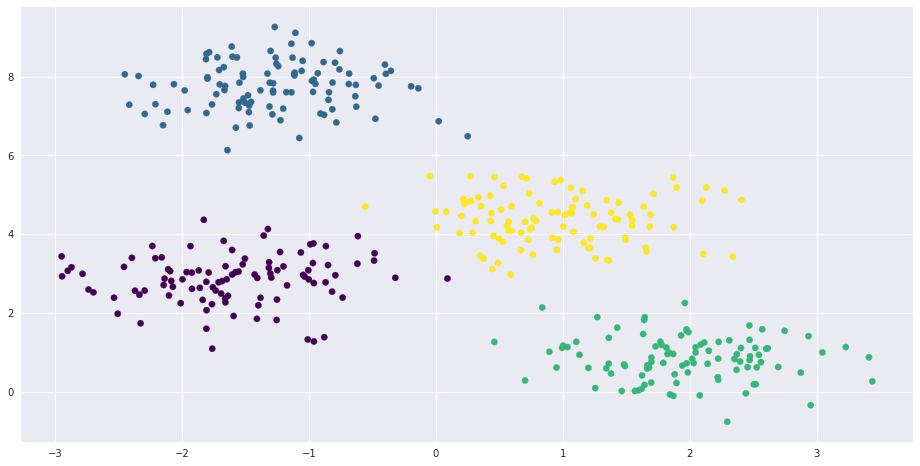

In [7]:
# Plot the data with K Means Labels
from sklearn.cluster import KMeans
kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

From an intuitive standpoint, we might expect that the clustering assignment for some points is more certain than others: (__soft boundary and hard boundary__) for example, there appears to be a very __slight overlap__ between the two middle clusters, such that we might not have complete confidence in the cluster assigment of points between them.(but the *k*-means model has no intrinsic measure of probability or uncertainty of cluster assignments)

> Generalize the model?

One way to think about the *k*-means model is that __it places a circle (or, in higher dimensions, a hyper-sphere) at the center of each cluster, with a radius defined by the most distant point in the cluster.__

This radius acts as a __hard cutoff__ for cluster assignment within the training set: any point outside this circle is not considered a member of the cluster.


In [22]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=1, ax=None):
    labels = kmeans.fit_predict(X)

    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    max_r = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, max_r):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=1, alpha=0.5, zorder=1))

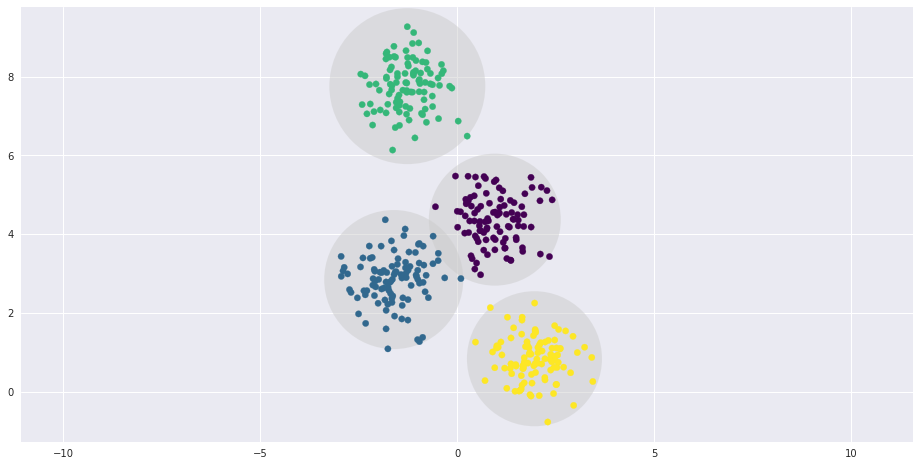

In [23]:
kmeans = KMeans(n_clusters=4, random_state=1)
plot_kmeans(kmeans, X)

An important observation for *k*-means is that these cluster models __must be circular__: 

__k-means has no built-in way of accounting for oblong or elliptical clusters.__

So, for example, if we take the same data and transform it, the cluster assignments end up becoming messy:

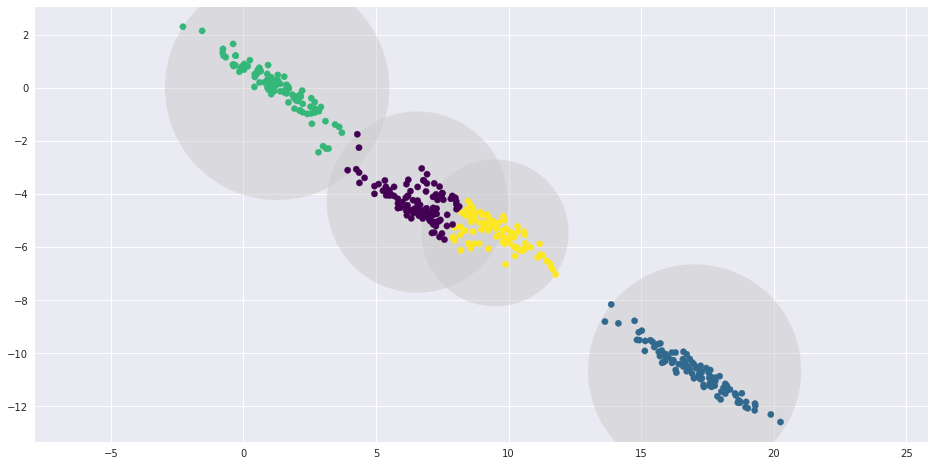

In [24]:
rng = np.random.RandomState(2018)
X_stretched = np.dot(X, rng.randn(2, 2))

kmeans = KMeans(n_clusters=4, random_state=2018)
plot_kmeans(kmeans, X_stretched)

we see that these transformed clusters are non-circular, and thus circular clusters would be a poor fit.

Nevertheless, *k*-means is not flexible enough to account for this, and __tries to force-fit the data into four circular clusters.__

> solutions?

Generalize the *k*-means model: 

for example:

- measure uncertainty in cluster assignment by __comparing the distances of each point to *all* cluster centers, rather than focusing on just the closest.__


- allow the cluster boundaries to be ellipses rather than circles, so as to account for non-circular clusters.


### Generalizing E–M: Gaussian Mixture Models

A Gaussian mixture model (GMM) attempts to find a mixture of __multi-dimensional Gaussian probability distributions that best model any input dataset.__


In the simplest case, GMMs can be used for finding clusters in the same manner as *k*-means:

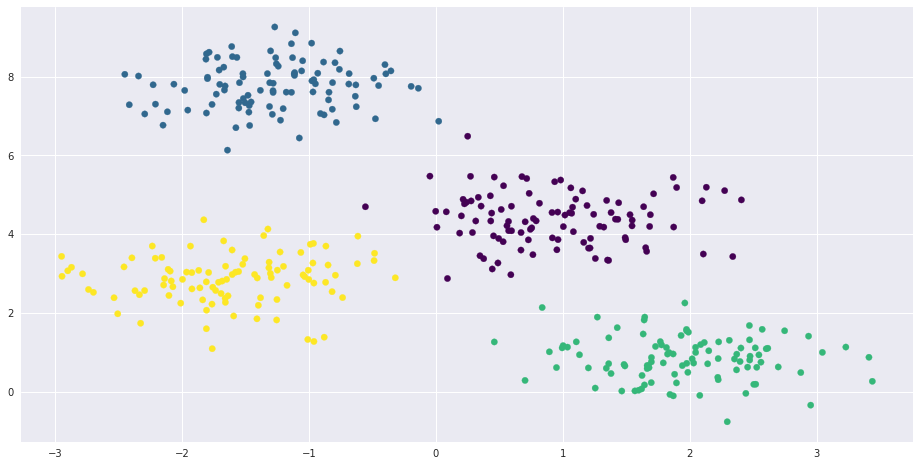

In [26]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

But because GMM contains a probabilistic model under the hood, it is __also possible to find probabilistic cluster assignments__(``predict_proba`` method in sklearn)


This returns a matrix of size ``[n_samples, n_clusters]`` which measures the probability that any point belongs to the given cluster:

In [33]:
probs = gmm.predict_proba(X)
probs.shape # (num, features)

(400, 4)

In [34]:
probs.round(3)

array([[ 0.531,  0.469,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  1.   ],
       [ 0.   ,  0.   ,  0.   ,  1.   ],
       ..., 
       [ 0.   ,  0.   ,  1.   ,  0.   ],
       [ 0.536,  0.   ,  0.   ,  0.463],
       [ 0.   ,  0.   ,  1.   ,  0.   ]])

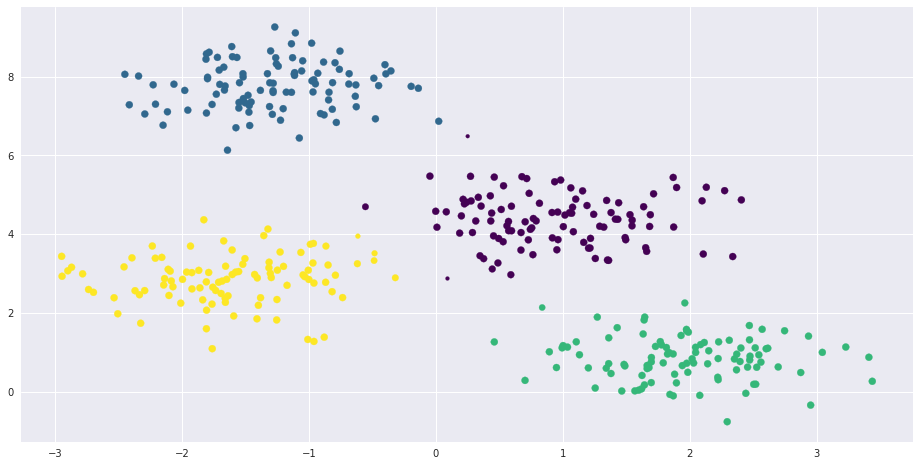

In [35]:
size = 50 * probs.max(1) ** 2  # square amplifies the differences
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=size);

Under the hood, a Gaussian mixture model is very similar to *k*-means: it __uses an expectation–maximization approach__ which qualitatively does the following:

1. Choose starting guesses for the location and shape

2. Repeat until converged:

   1. *E-step*: for each point, find weights encoding __the probability of membership in each cluster__
   2. *M-step*: for each cluster, __update its location, normalization, and shape based on *all* data points__, making use of the weights

The result of this is that __each cluster is associated not with a hard-edged sphere, but with a smooth Gaussian model.__

Just as in the *k*-means expectation–maximization approach, this algorithm can __sometimes miss the globally optimal solution__, and thus in practice multiple random initializations are used.



In [36]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    # Draw an ellipse with a given position and covariance
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        

In [40]:
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

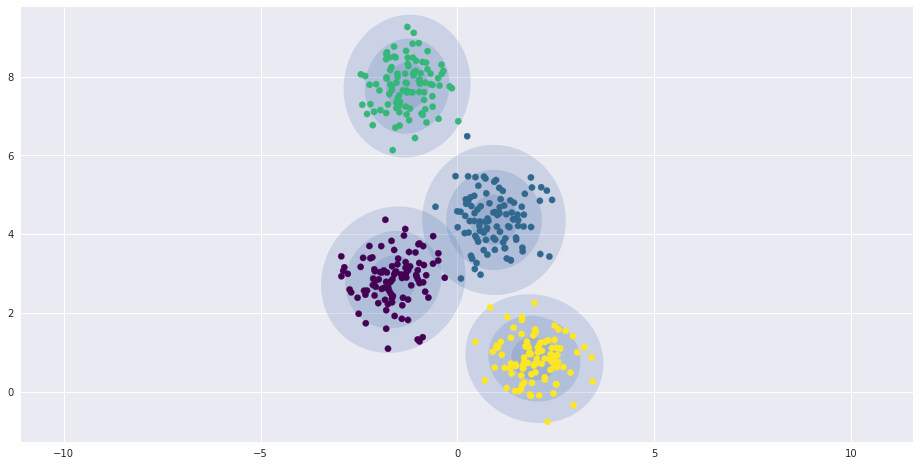

In [42]:
gmm = GaussianMixture(n_components=4, random_state=2018)
plot_gmm(gmm, X)

Similarly, we can use the GMM approach to fit our stretched dataset; __allowing for a full covariance the model will fit even very oblong, stretched-out clusters:__

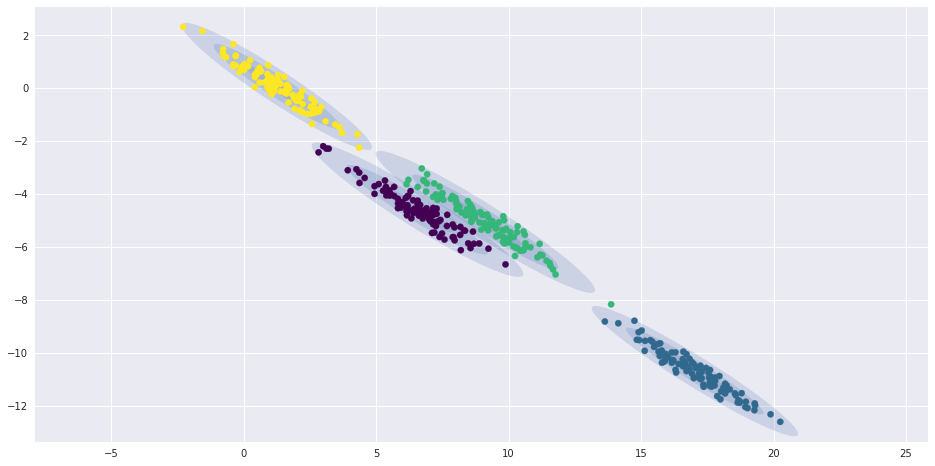

In [47]:
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=2018)
plot_gmm(gmm, X_stretched)

## GMM as *Density Estimation*

Though GMM is often categorized as a clustering algorithm, fundamentally it is an algorithm for *density estimation*, the result of a GMM fit to some data is technically not a clustering model, but __a generative probabilistic model describing the distribution of the data.__


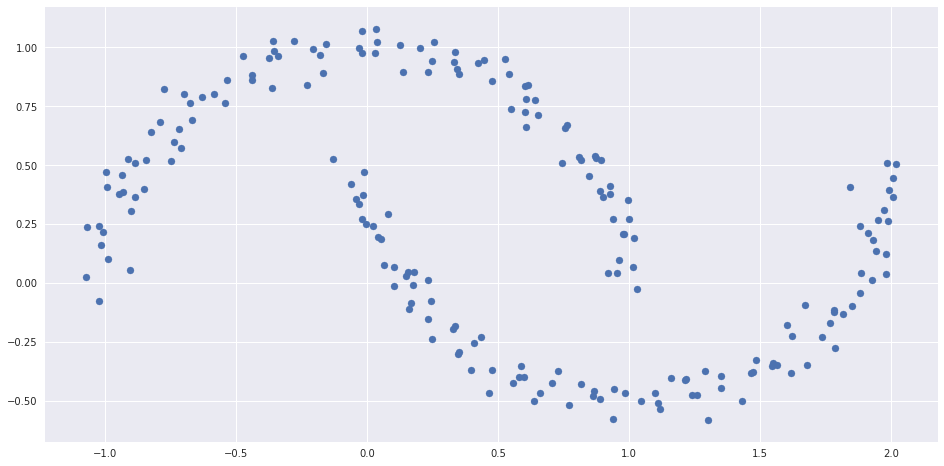

In [48]:
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1]);

If we try to fit this with a two-component GMM viewed as a clustering model, the results are not particularly useful:

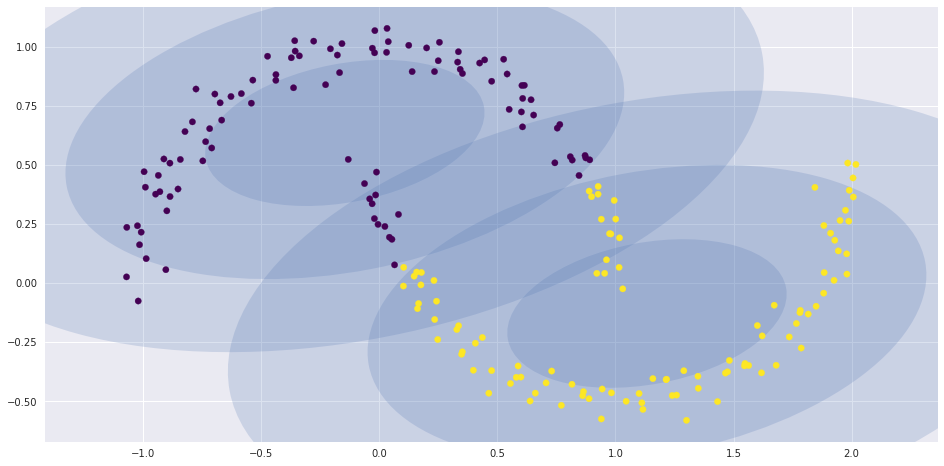

In [51]:
gmm2 = GaussianMixture(n_components=2, covariance_type='full', random_state=2018)
plot_gmm(gmm2, Xmoon)

But if we instead 

- __use many more components__ 
- __ignore the cluster labels__


we find a fit that is much closer to the input data:

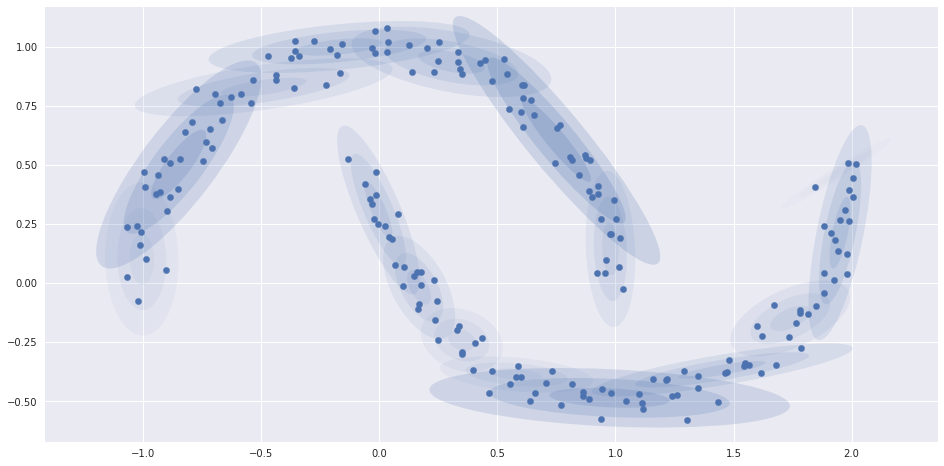

In [53]:
gmm16 = GaussianMixture(n_components=16, covariance_type='full', random_state=0)
plot_gmm(gmm16, Xmoon, label=False)

Here the mixture of 16 Gaussians __serves not to find separated clusters of data, but rather to model the overall *distribution* of the input data.__

This is a generative model of the distribution, meaning that the __GMM can generate new random data distributed similarly to our input.__


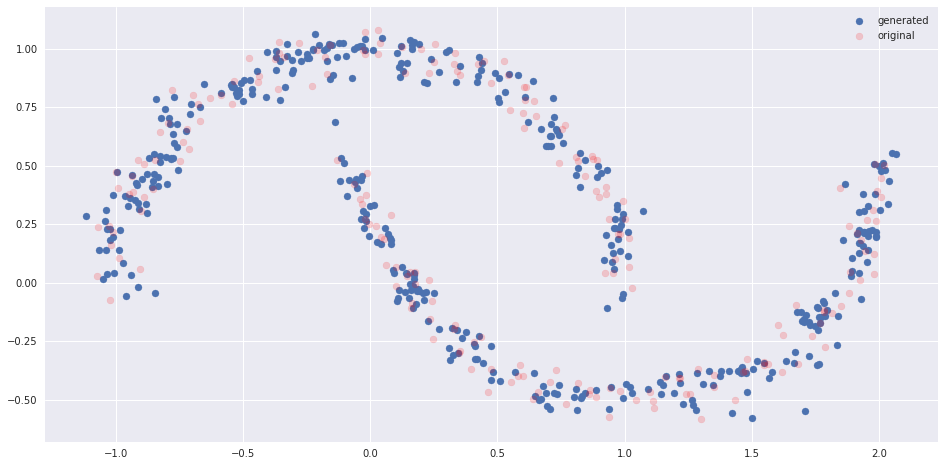

In [63]:
Xnew = gmm16.sample(400)[0]
plt.scatter(Xnew[:, 0], Xnew[:, 1], label="generated")
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1], c='red', label="original", alpha=0.17)
plt.legend()

### How many components?

__The fact that GMM is a generative model gives us a natural means of determining the optimal number of components for a given dataset.__


__A generative model is inherently a probability distribution for the dataset__, and so we can simply __evaluate the *likelihood*__ of the data under the model, using cross-validation to avoid over-fitting.


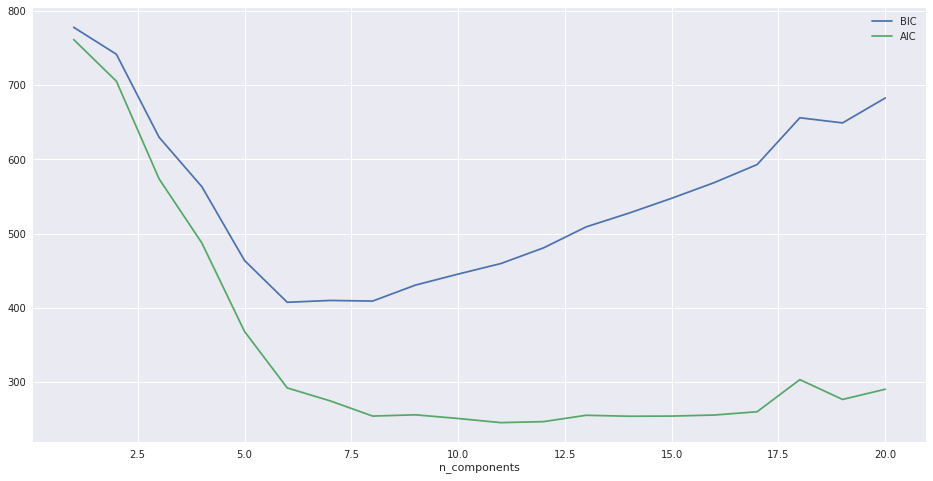

In [64]:
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(Xmoon)
          for n in n_components]

plt.plot(n_components, [m.bic(Xmoon) for m in models], label='BIC')
plt.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

## Example: GMM as Generative Model

In [65]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

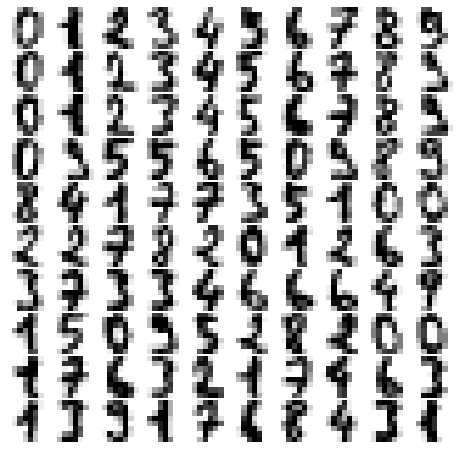

In [66]:
def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(digits.data)

Notes:

- GMMs can have difficulty converging in such a high dimensional space
- so start with an invertible dimensionality reduction algorithm on the data (preserve 99% of the variance in the projected data)

In [67]:
from sklearn.decomposition import PCA
pca = PCA(0.99, whiten=True)
data = pca.fit_transform(digits.data)
data.shape

(1797, 41)

The result is 41 dimensions, a reduction of nearly 1/3 with almost no information loss.


Given this projected data, let's __use the AIC to get a guess for the number of GMM components__ we should use:

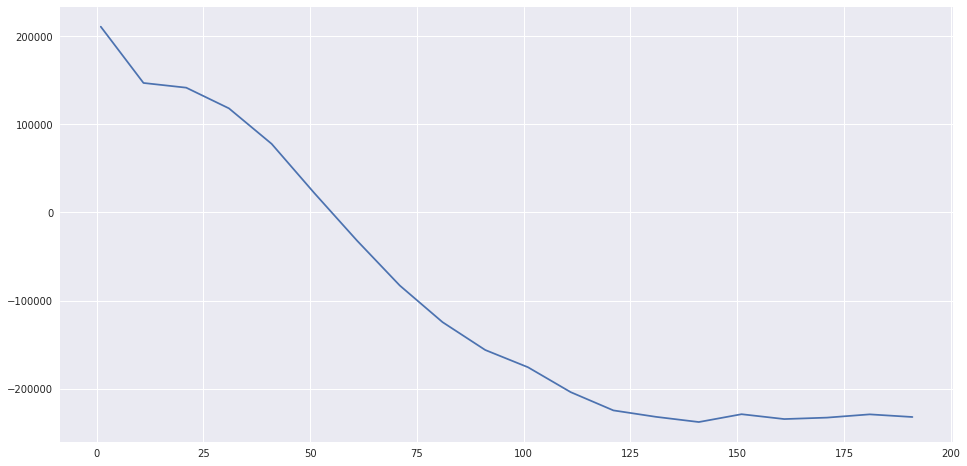

In [69]:
n_components = np.arange(1, 200, 10)
models = [GaussianMixture(n, covariance_type='full', random_state=0)
          for n in n_components]
aics = [model.fit(data).aic(data) for model in models]
plt.plot(n_components, aics);

In [70]:
gmm = GaussianMixture(150, covariance_type='full', random_state=0)
gmm.fit(data)
print(gmm.converged_)

True


Now we can draw samples of 100 new points within this 41-dimensional projected space, using the GMM as a generative model:

In [72]:
data_new = gmm.sample(100)[0]
data_new.shape

(100, 41)

Finally, we can __use the inverse transform of the PCA object to construct__ the new digits:

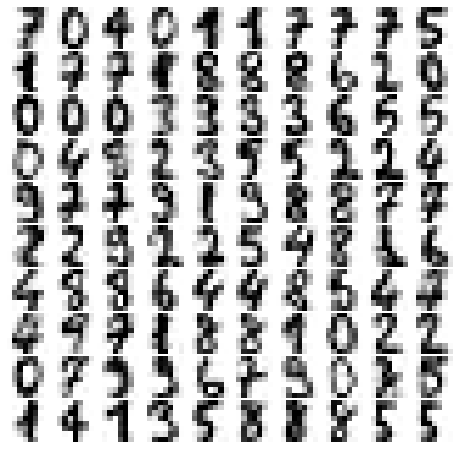

In [73]:
digits_new = pca.inverse_transform(data_new)
plot_digits(digits_new)